# INDEX

## 1. Construct training and testing datasets for logistic regression

## 2. Logistic regression with statsmodels

## 3. Logistic Regression with sklearn

## 4. Logistic Regression with Tensorflow

## 5. Neural Network with Tensorflow



In [1]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.22.1


In [2]:
import pickle
import glob

os.chdir(r'C:\Users\Heath\OneDrive\PythonProjects\2020\2020_RLforFinance\data')
pickle_data = glob.glob('*')

pickle_names = ['df_closure_learn', 'df_data', 'df_test', 'df_train']
for i in range(len(pickle_data)):
    with open(pickle_data[i], 'rb') as f:
        pickle_names[i] = pd.read_pickle(f)

df_closure_learn, df_data, df_test, df_train = [pickle_names[i] for i in range(4)] 
print(df_closure_learn.index.names)

['IDRSSD', 'date']


In [3]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [4]:
print(df_train.columns)
df_train['defaulter']

Index(['Financial Institution Name', 'Institution Name ', 'total_assets',
       'defaulter', 'Failure / Assistance ', 'log_TA', 'NI_to_TA',
       'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL',
       'core_deposits_to_TA', 'brokered_deposits_to_TA', 'liquid_assets_to_TA',
       'loss_provision_to_TL', 'ROA', 'NIM', 'assets_growth', 'term_spread',
       'stock_mkt_growth', 'real_gdp_growth', 'unemployment_rate_change',
       'treasury_yield_3m', 'bbb_spread', 'bbb_spread_change',
       'log_TA_plus_1Q', 'NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q',
       'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 'ALLL_to_TL_plus_1Q',
       'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q',
       'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q',
       'ROA_plus_1Q', 'NIM_plus_1Q', 'assets_growth_plus_1Q',
       'default_within_1Y', 'Failure', 'max_total_assets', 'num_records',
       'non_defaulter', 'const'],
      dtype='object')


IDRSSD   date      
904957   2008-03-31    1.0
202907   2011-06-30    0.0
652874   2012-12-31    0.0
9115     2003-03-31    0.0
3344611  2012-06-30    1.0
                      ... 
612618   2002-12-31    0.0
165628   2007-09-30    0.0
2685764  2008-09-30    1.0
101019   2002-12-31    0.0
596400   2002-06-30    0.0
Name: defaulter, Length: 641, dtype: float64

In [5]:
df_train[MEV_cols]

,,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
IDRSSD,date,,,,,,,
904957,2008-03-31,0.155788,-0.317435,-0.253927,0.859609,0.006692,0.894064,0.417366
202907,2011-06-30,0.897368,-0.132755,0.348841,0.202649,-0.956664,-0.324746,-0.095051
652874,2012-12-31,-0.400396,0.188968,-0.387875,-0.782792,-0.896455,0.081524,0.161157
9115,2003-03-31,0.433881,1.674053,0.951609,0.531129,-0.354567,-0.189323,-0.863677
3344611,2012-06-30,-0.585791,-0.510166,-0.521824,-0.125832,-0.896455,0.894064,0.417366
...,...,...,...,...,...,...,...,...
612618,2002-12-31,0.433881,1.674053,0.951609,0.531129,-0.354567,-0.189323,-0.863677
165628,2007-09-30,-1.698161,0.042048,0.214893,0.531129,1.632356,-0.460169,0.929783
2685764,2008-09-30,0.248486,-1.207668,-2.865922,2.173530,-0.053518,1.435757,1.185992


## Construct training and testing datasets for logistic regression

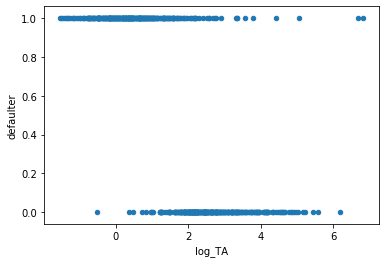

In [6]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

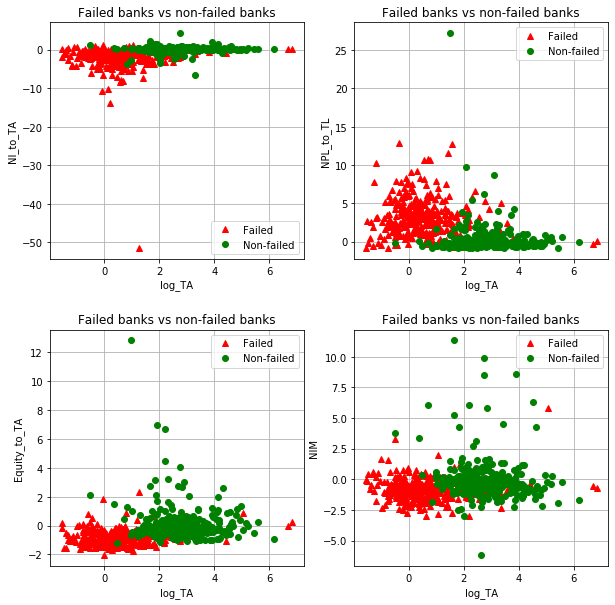

In [7]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [8]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.  # roc_auc, accuracy_score, ks
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [9]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 

    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [10]:
# look at correlations
df_train[MEV_cols].corr()  # wow

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Perform logistic regression using **cols_to_use** as predictors. Use df_train pandas DataFrame as training data set, and df_test pandas DataDrame as testing data set to perform prediction based on the already trained model. Utilize statsmodels package. The result of fitting logistic regression should be assigned to variable named **model**

In [11]:
import statsmodels.api as sm
from sklearn import metrics

Optimization terminated successfully.
         Current function value: 0.159379
         Iterations 9


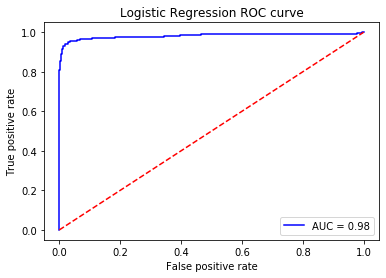

Accuracy score 0.959438
AUC score 0.981497
Kolmogorov-Smirnov statistic 0.921836


In [12]:
cols_to_use = state_cols + MEV_cols  + ['const']
model = None
df_train['const'] = 1

# df_train[cols_to_use]
logit = sm.Logit(df_train['defaulter'], df_train[cols_to_use])
model = logit.fit()  # statsmodel.api

# prediction
predicted_sm = np.array([])

if model is not None:
    predicted_sm = model.predict(df_test[cols_to_use], linear=False)

threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)
auc_score, accuracy_score, ks = calc_metrics(model, df_test[cols_to_use], df_test['defaulter'])

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

## Logistic Regression with sklearn

### Part 2 
In Part 2 you will use scikit-learn to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, test it using teX, thisTeY and compute logistic regression score.

- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [13]:
from sklearn import neighbors, linear_model

trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.0
thisTrY = trY[:,0]
thisTeY = teY[:,0]

logistic = None
result = None

logistic = linear_model.LogisticRegression(random_state=42, penalty='l1', tol=1e-6, C=1000.0, solver='liblinear')
result = logistic.fit(trX, thisTrY)
lr_score = result.score(teX, thisTeY)

print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.959438


In [32]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ] + ['term_spread', 'stock_mkt_growth']

lr_score = 0.
logistic = None
result = None

trX = df_train[cols_to_use].values
teX = df_test[cols_to_use].values
thisTrY = (df_train.defaulter.values)
thisTeY = (df_test.defaulter.values)
logistic = linear_model.LogisticRegression(penalty='l1', tol=1e-6, C=1000.0, solver='liblinear')
result = logistic.fit(trX, thisTrY)
lr_score = result.score(teX, thisTeY)
print('LogisticRegression score: %f' % lr_score)

# combine results of the Logistic Regression to a small dataframe df_coeffs_LR
df_coeffs_LR = pd.DataFrame({0: np.array([0.] * (len(cols_to_use) + 1), dtype=np.float32)})
if logistic is not None:
    model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
    df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
print(df_coeffs_LR)

LogisticRegression score: 0.954758
                                0
log_TA                  -1.473224
NI_to_TA                -0.797119
Equity_to_TA            -1.884342
NPL_to_TL                0.338078
core_deposits_to_TA     -0.502666
brokered_deposits_to_TA  0.023560
liquid_assets_to_TA     -0.513414
term_spread              0.011348
stock_mkt_growth         0.026439
const                   -0.093846


## Logistic Regression with Tensorflow

In [17]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 641


In [18]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [19]:
## BUILD LOGISTIC REGRESSION TF MODEL

import tensorflow as tf

# define the model
reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)

# build Logistic Regression model using Tensorflow

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")

logits = tf.matmul(X, theta)
y_proba = tf.sigmoid(logits) # 1 / (1 + tf.exp(-logits))

# uses epsilon = 1e-7 by default to regularize the log function
loss = tf.losses.log_loss(y, y_proba, epsilon=1e-07)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [21]:
## TRAIN LOGISTIC REGRESSION TF MODEL
# TF1?

n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:  # TODO: Update the lines
    for epoch in range(n_epochs):
        sess.run(init)
        X_trainTf_batch, y_trainTf_batch = random_batch(X_trainTf, y_trainTf, batch_size)
        sess.run([optimizer, loss], feed_dict={X: X_trainTf_batch, y: y_trainTf_batch})
    
    y_proba_val = sess.run(y_proba, feed_dict={X: X_testTf})

In [22]:
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

320


In [23]:
y_pred.squeeze()

array([ True, False, False,  True,  True,  True, False,  True, False,
        True,  True, False,  True,  True, False, False,  True, False,
        True,  True, False,  True,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
       False, False,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False,  True,  True,  True, False, False,  True, False,  True,
        True,  True, False, False, False, False, False,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False, False,  True, False, False,
        True,  True,

precision:  0.796875
recall:  0.819935691318328
AUC score =  0.870593393744519
roc_auc =  0.870593393744519
KS_test =  0.6343466822566501


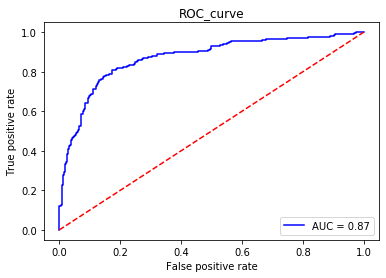

In [24]:
# evaluate precision, recall, and AUC

auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass

## Neural Network with Tensorflow

In [25]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [26]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Construct Neural Network

**Instructions**
Implement Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [27]:
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

layer_1 = neuron_layer(X, n_hidden1, "layer_1", tf.nn.relu)
layer_2 = neuron_layer(layer_1, n_hidden2, "layer_2", tf.nn.relu)
logits = neuron_layer(layer_2, n_outputs, "logits")
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(entropy)
init = tf.global_variables_initializer()

### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**


In [29]:
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
with tf.Session() as sess:
    sess.run(init)
    for i in range(n_epochs):
        X_trainTf_batch, y_trainTf_batch = random_batch(X_trainTf, y_trainTf, batch_size)
        sess.run([optimizer, loss], feed_dict={X: X_trainTf_batch, y: y_trainTf_batch})
    
    _, loss, logits = sess.run([optimizer, loss, logits], feed_dict={X: X_testTf, y: y_testTf})
    preds = tf.nn.softmax(logits)
    correct_preds = tf.equal(tf.argmax(preds, 1), y_testTf)
    acc_test = sess.run(tf.reduce_sum(tf.cast(correct_preds, tf.float32))) / len(y_testTf)

In [33]:
acc_test 

0.9048361934477379